## 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Loading Relevant Information](#5.4_Loading_Relevant_Information)
  * [5.5 Train/Test Split](#5.5_Train_Test_Split)
  * [5.6 Summary](#5.6_Summary)

## 5.2 What's the problem?<a id='What"s the problem?'></a>

The problem here is defaulting on credit card loans. The failure to repay has broken the initial arangement between the borrower and the financial institution. A step in the right direction that's beneficial for both parties is robust risk assessment. Successfully predicting whether potential borrwers will have payment issues or not is what this final model will try to accomplish.

The Documentation notebook will explore the relationships between borrowers and defaulting and will answer questions posed by the story-telling report.

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import warnings
from imblearn.over_sampling import RandomOverSampler,SMOTE
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import __version__ as sklearn_version
from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix

In [3]:
os.chdir(r'C:\Users\daenj\OneDrive\Desktop\Datasets\Capstone 2021')
os.getcwd()

'C:\\Users\\daenj\\OneDrive\\Desktop\\Datasets\\Capstone 2021'

## 5.4 Loading Relevant Information<a id='5.4_Loading_Relevant_Information'></a>

In [4]:
import pickle
filename = 'final_model.sav'
svm_model = pickle.load(open(filename, 'rb'))

In [5]:
#Loading the model that was built in the last notebook.
svm_model

LinearSVC()

In [6]:
data = pd.read_csv('data.csv')
data = data.drop(columns="Unnamed: 0")

In [7]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## 5.5 Train/Test Split<a id='5.5_Train_Test_Split'></a>

In [8]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']
print(X.shape)
print(y.shape)

(307511, 122)
(307511,)


In [9]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 0)

In [10]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
svm_model = svm_model.fit(X_train, y_train)

## Support Vector Machine<a id='Support_Vector_Machine'></a>

Due to the imbalance of the data, the important metrics are precision, recall, and the f1 score. The first few metrics to check with this SVM are the average precision and the precision-recall curve.

In [12]:
from sklearn.metrics import average_precision_score

y_score = svm_model.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.15


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.15')

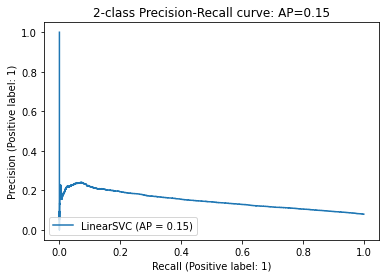

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svm_model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

The average precision of this linear svc is above the baseline.

When a model has high recall but low precision, then the model classifies most of the positive samples correctly but it has many false positives (i.e. classifies many Negative samples as Positive). 

A bank using a risk assessment model like this is essentially not predicting true positives (a positive prediction + the borrower actually defaulting).

In [14]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score


y_pred = svm_model.predict(X_test)

In [16]:
def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred_sr = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred_sr[i]==1:
           TP += 1
        if y_pred_sr[i]==1 and y_true[i]!=y_pred_sr[i]:
           FP += 1
        if y_pred_sr[i]==0 and y_test[i]!=y_pred_sr[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1

    return precision, recall

# Test function

calc_precision_recall(y_test, y_pred)

(0.05128205128205128, 0.00027247956403269756)

This imbalanced dataset is not doing any of these models any favors. There are barely any false positives or true positives. In a later section, the imbalance will be corrected and the metrics will be evaluated again.

In [36]:
import sklearn.metrics

precision = sklearn.metrics.precision_score(y_test, y_pred, pos_label = 1, average='weighted')

recall = sklearn.metrics.recall_score(y_test, y_pred, pos_label = 1, average='weighted')

f1 = f1_score(y_test, y_pred, pos_label = 1, average='weighted')

print('Support Vector Machine (SVM): precision-score=%.3f' % (precision))
print('Support Vector Machine (SVM): recall-score=%.3f' % (recall))
print('Support Vector Machine (SVM): f1-score=%.3f' % (f1))

Support Vector Machine (SVM): precision-score=0.847
Support Vector Machine (SVM): recall-score=0.920
Support Vector Machine (SVM): f1-score=0.882


A perfect f1-score is a 1. In this case, the f1-score of 0.882 means that the model predicts low false positives and low false negatives.

Confusion matrix, without normalization
[[84877    37]
 [ 7338     2]]
Normalized confusion matrix
[[1.00e+00 4.36e-04]
 [1.00e+00 2.72e-04]]


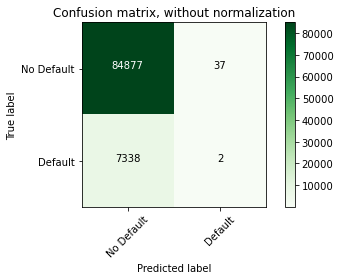

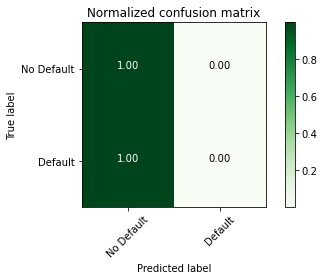

In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names=['No Default','Default'] 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

The confusion matrix for the SVM model has a 37 labeled false positives and 2 true positives. However, compared to the true negatives and false negatives, the FP and TP's are neglible and basically zero.

## Logistic Regression<a id='Logistic_Regression'></a>

In [19]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('normalizer', StandardScaler()), #Step1 - normalize data
    ('clf', LogisticRegression()) #step2 - classifier
])
pipeline.steps

[('normalizer', StandardScaler()), ('clf', LogisticRegression())]

In [20]:
pipeline = pipeline.fit(X_train, y_train)

In [21]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84914
           1       0.00      0.00      0.00      7340

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



In [22]:
cm_lr = confusion_matrix(y_test, y_pred)
print(cm_lr)

[[84908     6]
 [ 7340     0]]


The classification report for this model gives a weighted average f1 score of 0.88, just like the SVM model and the RF model down below.

In [23]:
# Fit and predict test class probabilities

y_test_probs = pipeline.predict_proba(X_test)[:,1]

# Containers for true positive / false positive rates
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(y_test, y_test_preds)
        
    precision_scores.append(precision)
    recall_scores.append(recall)

In [24]:
# Fit and predict test class probabilities
lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
lr_l2.fit(X_train, y_train)
y_test_probs = lr_l2.predict_proba(X_test)[:,1]

# Containers for true positive / false positive rates
l2_precision_scores = []
l2_recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(y_test, y_test_preds)
        
    l2_precision_scores.append(precision)
    l2_recall_scores.append(recall)

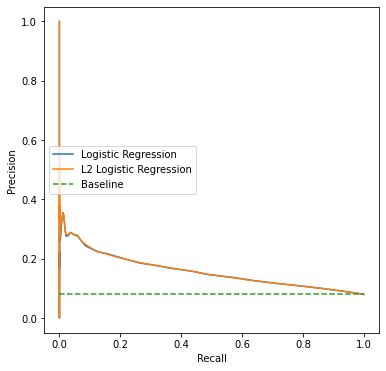

In [25]:
# Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='Logistic Regression')
ax.plot(l2_recall_scores, l2_precision_scores, label='L2 Logistic Regression')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

The precision-recall curves of both the logistic regression pipeline and the svm model are identical. Both of the curve's average precisions are above the baseline. 

## Random Forest<a id='Random_Forest'></a>

In [26]:
from sklearn.ensemble import RandomForestClassifier
#Apply RF to the training data:

rf = RandomForestClassifier(bootstrap=True,n_estimators=100,criterion='entropy')

#Predict using the model:

model_rf = rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print('Random Forest : f1-score=%.3f' % (f1_rf))

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_pred_rf)
print(cnf_matrix)

Random Forest : f1-score=0.882
[[84914     0]
 [ 7340     0]]


## Various Machine Learning Algorithms<a id='Various_Machine_Learning_Algorithms'></a>

In [27]:
def ml_model(X_train,X_test, y_train, y_test):
  MLA = [KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression()]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted),2)
    row_index+=1
  MLA_compare.sort_values(by = ['F1 score'], ascending = False, inplace = True)    
  return MLA_compare  
ml_model(X_train,X_test, y_train, y_test)

,Model Name,Precision,Recall,F1 score
1,DecisionTreeClassifier,0.09,0.18,0.12
0,KNeighborsClassifier,0.14,0.01,0.03
2,LogisticRegression,0.00,0.00,0.00


The vanilla logistic regression model produced no useful information. Is this due to the class imbalance?

## Fixing Imbalanced Data<a id='Fixing_Imbalanced_Data'></a>

This next section takes the minority class (target = 1) and increases the number of instances in the minority class by randomly replicating them.

In [28]:
print('before Oversampling:',Counter(y_train))
oversample = RandomOverSampler(sampling_strategy='minority')
X_train1, y_train1 = oversample.fit_resample(X_train, y_train)
print('After Oversampling:',Counter(y_train1))

before Oversampling: Counter({0: 197772, 1: 17485})
After Oversampling: Counter({0: 197772, 1: 197772})


In [29]:
oversampling = ml_model(X_train1,X_test, y_train1, y_test)
oversampling

,Model Name,Precision,Recall,F1 score
2,LogisticRegression,0.13,0.63,0.21
0,KNeighborsClassifier,0.10,0.28,0.14
1,DecisionTreeClassifier,0.11,0.11,0.11


The oversampling increased the f1 score and recall for all models!

In [30]:
print('before SMOTE:',Counter(y_train))
sm = SMOTE(sampling_strategy='minority')
X_train2, y_train2 = sm.fit_resample(X_train, y_train)
print('After SMOTE:',Counter(y_train2))

before SMOTE: Counter({0: 197772, 1: 17485})
After SMOTE: Counter({0: 197772, 1: 197772})


In [31]:
Smote = ml_model(X_train2,X_test, y_train2, y_test)
Smote

,Model Name,Precision,Recall,F1 score
2,LogisticRegression,0.13,0.61,0.21
0,KNeighborsClassifier,0.10,0.44,0.16
1,DecisionTreeClassifier,0.08,0.94,0.15


The Smote method increased the f1 scores of all the models. Recall is also increased for all the models as well.

In [32]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))  

                                          Feature     Score
11                                     FLAG_MOBIL  0.065487
14                               FLAG_CONT_MOBILE  0.065270
48               NAME_HOUSING_TYPE_Houseapartment  0.052863
12                                 FLAG_EMP_PHONE  0.044424
19                    REGION_RATING_CLIENT_W_CITY  0.039193
18                           REGION_RATING_CLIENT  0.037311
42  NAME_EDUCATION_TYPE_Secondarysecondaryspecial  0.033730
31                              FLAG_OWN_REALTY_Y  0.031727
43                     NAME_FAMILY_STATUS_Married  0.026759
17                                CNT_FAM_MEMBERS  0.020658


The features above are the ten most relevant features in determining potential default or not. Let's build varoius models to see if the results are different when only training on the top 10 most important features.

In [33]:
X1 = data[['FLAG_CONT_MOBILE','FLAG_MOBIL','NAME_HOUSING_TYPE_Houseapartment','FLAG_EMP_PHONE','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT',
           'NAME_EDUCATION_TYPE_Secondarysecondaryspecial','FLAG_OWN_REALTY_Y','NAME_FAMILY_STATUS_Married','CNT_FAM_MEMBERS']]
X_train, X_test, y_train, _test = train_test_split(X1, y, test_size= 0.3, random_state = 0)
Feature_selection = ml_model(X_train,X_test, y_train, y_test)
Feature_selection

,Model Name,Precision,Recall,F1 score
0,KNeighborsClassifier,0.10,0.0,0.01
1,DecisionTreeClassifier,0.17,0.0,0.00
2,LogisticRegression,0.00,0.0,0.00


## 4.12 Summary<a id='4.12_Summary'></a>

There were a handful of models that were used in this notebook. The SVM and Random Forest models gave the best f1 score (0.882). In this classification problem, accuracy is not the best metric for these models. Precision, recall and the f1 score are better indicators of performance. While using oversampling and SMOTE to randomly increase instances of the minority class imporved metrics for the logistic regression, K-neighbors, and the decision tree models, the best model in this case is the SVM model. The SVM model gave the best f1 score and also provided instances of TP, FP, TN, and FN. A model that doesn't predict false positives or true positives is not very useful! Finally, the top features associated with defaulting were identified and modeled. 